In [1076]:
import os
import itertools
from functools import reduce
from collections import Counter

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

import pandas
import seaborn
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px

from lab_v2.io import read_file

In [1077]:
# FILE PATHS
DRAW_T07 = './data/draw/draw-T0.7.jsonl' 
LAST_LETTERS_T07 = './data/last_letters/last_letters-T0.7.jsonl' 
LAST_LETTERS_T07 = './data/csqa/csqa-T0.7.jsonl' 

ATTRIBUTES = ["majority_distance", "majority_distance_squared", "shannon_entropy", "gini_impurity"]
SCORES = ['r2', 'neg_root_mean_squared_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'max_error']
CLASS = 'num_correct'

DATA_EXPLORATION = True

FILE_PATH = LAST_LETTERS_T07
CACHE = 'cache/csqa/csqa-T0.3.json'

In [1078]:
data = read_file(FILE_PATH)
data['num_correct'] = data['num_correct'].apply(lambda row : row)
data.head(1)

,majority_distance,majority_distance_squared,shannon_entropy,gini_impurity,majority_correct,num_correct
0,0.397377,0.157908,2.121699,0.845,False,0


## **Data exploration**

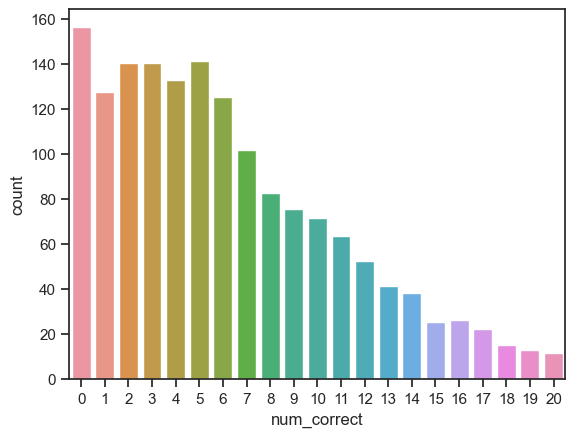

In [1079]:
if DATA_EXPLORATION:
    count = dict(Counter(data['num_correct']))
    count = sorted(count.items(), key=lambda x: x[0])
    ax = seaborn.barplot(count, errorbar=None)
    ax.set(xlabel='num_correct', ylabel='count')

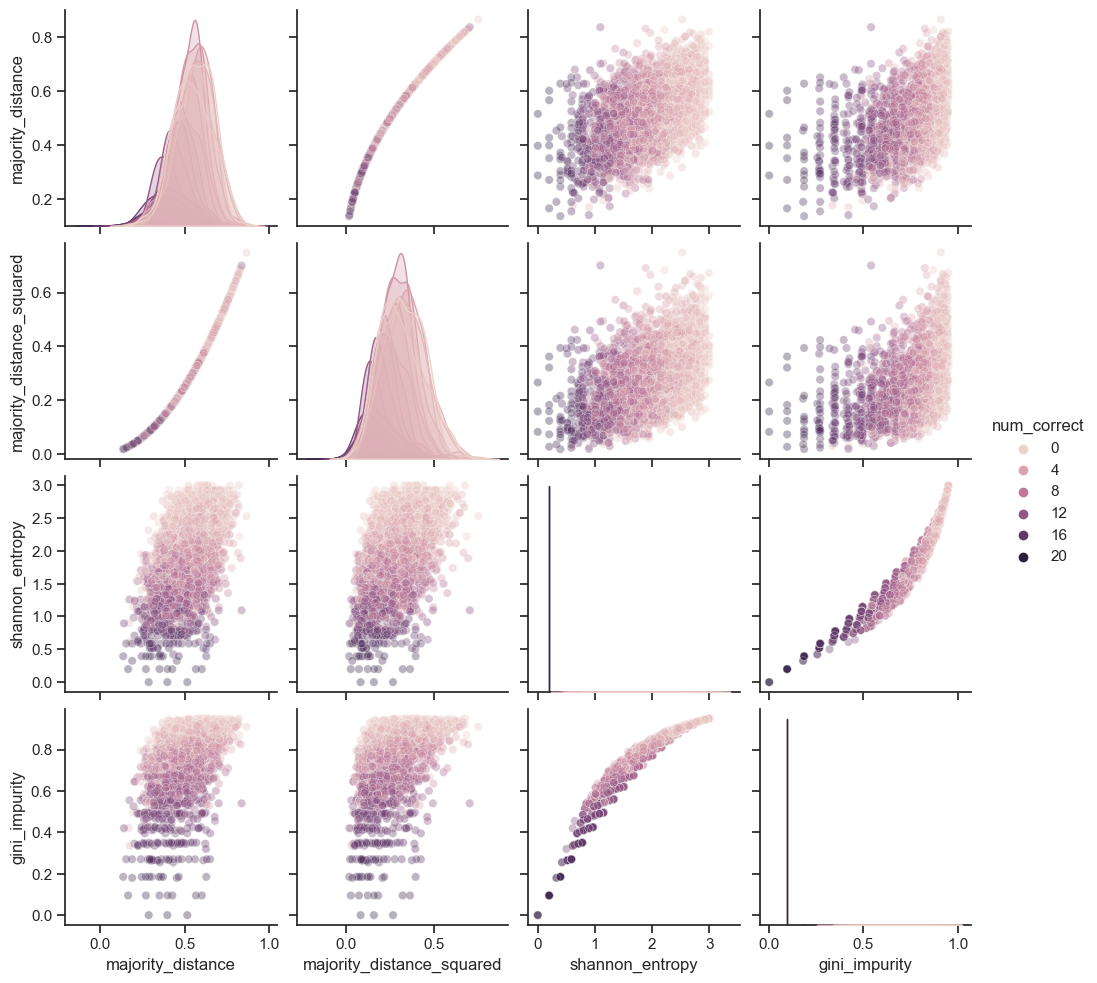

In [1080]:
if DATA_EXPLORATION: 
    seaborn.set_theme(style='ticks')
    seaborn.pairplot(data[[*ATTRIBUTES, CLASS]], hue=CLASS, plot_kws={'alpha': 0.35})
    print('')

In [1081]:
if DATA_EXPLORATION:
    fig = px.scatter_3d(data, x='majority_distance', y='shannon_entropy', z='gini_impurity', color=CLASS)
    fig.update_traces(marker=dict(size=3), selector=dict(mode='markers'))
    fig.update_traces(marker=dict(opacity=0.75), selector=dict(mode='markers'))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

In [1082]:
data_x = data[ATTRIBUTES]
data_y = data[CLASS]
display(data_x.head(1))
display(data_y.head(1))

,majority_distance,majority_distance_squared,shannon_entropy,gini_impurity
0,0.397377,0.157908,2.121699,0.845


0    0
Name: num_correct, dtype: int64

In [1083]:
classification_reports = []
def classification_report_scorer(y_true, y_pred):
    classification_reports.append(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

In [1084]:
import math
def report_average(report):
    report = report.copy()
    for r in report:
        report[r] = sum(report[r]) / len(report[r])
    return report

In [1085]:
# import sklearn
# sklearn.metrics.get_scorer_names()

In [1086]:
class MLExploration:
    SCORES_DICT = {s: '' for s in SCORES}
    TEMPLATE_DICT = {
        'model': '', 
        'hyperparameters': '',
        **SCORES_DICT
    }
    RANDOM_STATE = 42

    def __init__(self, data_x, data_y, scores, output_file_path):
        self.data_x = data_x
        self.data_y = data_y
        self.output_file_path = output_file_path

        self.scores = scores
        scores_dict = {s: '' for s in scores}
        template_dict = {
            'model': '', 
            'hyperparameters': '',
            **scores_dict
        }
        self.explored_models = pandas.DataFrame([template_dict])
        if os.path.exists(output_file_path): 
            self.explored_models = pandas.read_json(output_file_path, orient='split')


    def grid_search(self, model, parameters):
        parameter_combinations = self.__parameter_product(parameters)
        for combination in parameter_combinations:
            print(combination)
            self.explore_model(model, combination)

    def explore_model(self, model, hyperparameters):
        index = MLExploration.hash(model, hyperparameters)
        if index in self.explored_models.index: return self.explored_models.loc[index]

        scores = cross_validate(model(**hyperparameters), data_x, data_y, scoring=self.scores)
        filtered_scores = {s: scores[f'test_{s}'] for s in self.scores}
        average_scores = report_average(filtered_scores).values()

        self.explored_models.loc[index] = [
            MLExploration.hash_model(model), 
            MLExploration.hash_hyperparameters(hyperparameters),
            *average_scores
        ]
        self.explored_models.to_json(self.output_file_path, orient='split')

    def hash_model(model):
        return str(model.__name__)
    
    def hash_hyperparameters(hyperparameters):
       return str(sorted(hyperparameters.items(), key=lambda x:x[0]))
    
    def hash(model, hyperparameters):
        model = MLExploration.hash_model(model)
        hyperparameters = MLExploration.hash_hyperparameters(hyperparameters)
        return str((model, hyperparameters))
    
    def __parameter_product(self, parameters):
        keys, values = zip(*parameters.items())
        experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
        return experiments

## **Regression**

In [1087]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [1088]:
csqa_reg = MLExploration(data_x, 
                     data_y, 
                     ['r2', 'neg_root_mean_squared_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'max_error'],
                     CACHE)

In [1089]:
csqa_reg.explore_model(AdaBoostRegressor, {})
csqa_reg.explore_model(GradientBoostingRegressor, {})
csqa_reg.explore_model(RandomForestRegressor, {})
csqa_reg.explore_model(XGBRegressor, {})
csqa_reg.explore_model(GaussianProcessRegressor, {})
csqa_reg.explore_model(KNeighborsRegressor, {})
csqa_reg.explore_model(DecisionTreeRegressor, {})
csqa_reg.explore_model(MLPRegressor, {'max_iter': 10000})
print('')

In [1090]:
csqa_reg.explored_models.style.hide(axis='index')

model,hyperparameters,r2,neg_root_mean_squared_error,neg_median_absolute_error,neg_mean_absolute_error,max_error
,,,,,,
AdaBoostRegressor,[],0.340786,-5.566115,-2.452650,-3.918998,-18.842168
GradientBoostingRegressor,[],0.332465,-5.602659,-1.670877,-3.493938,-19.497899
RandomForestRegressor,[],0.206292,-6.093592,-1.276000,-3.626547,-19.962000
XGBRegressor,[],0.099333,-6.475855,-1.007585,-3.752570,-19.918621
GaussianProcessRegressor,[],-2.317232,-10.590219,-1.695351,-4.322612,-104.583773
KNeighborsRegressor,[],0.297723,-5.739037,-2.240000,-3.578497,-20.000000
DecisionTreeRegressor,[],-0.243509,-7.599239,-0.400000,-4.101612,-20.000000
MLPRegressor,"[('max_iter', 10000)]",0.400695,-5.317205,-2.102771,-3.512536,-20.305056
